In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import emoji
import re
import html
import pandas as pd
pretrained_id = "mdhugol/indonesia-bert-sentiment-classification"
label_id = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}

In [4]:
df = pd.read_csv('/kaggle/input/scraping-komang-2/scraping komang 2 - Sheet4.csv')
df2 = pd.read_csv('/kaggle/input/scraping-komang-3/scraping komang - Sheet3.csv')
df_fix = df.append(df2)
df_fix['Comment']

0       dengarkan juga vidio klip Snag Badut Raim Laod...
1                                          keren kao bang
2                                              Specless ❤
3          Terima kasih kerana membawa lagu ini ke dunia.
4       Video wedding yg ditonton se Indonesia. Semoga...
                              ...                        
3245                                         2 tahun lalu
3246                                               Mantap
3247    Nggak pernah bosen dengerin lagu ini syair &am...
3248                                             The best
3249    Best lagunya bang, Keren sangat. Beneran, mema...
Name: Comment, Length: 7453, dtype: object

# cleaning text

In [6]:
pip install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import string
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

def preprocess_tweet(tweet):
    tweet = tweet.lower() #Merubah format teks menjadi format huruf kecil semua (lowercase).
    # Remove HTML tags
    tweet = re.sub(r'<.*?>', '', tweet)
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    # Remove www URLs
    tweet = re.sub(r'www.\S+', '', tweet)

    #Menghapus karakter angka.
    tweet = re.sub('[^A-Za-z]+', ' ', str(tweet)) 
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    tweet = tweet.strip()
    
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    tweet = stemmer.stem(tweet)
    return tweet
df_fix['Cleaned Comment'] = df_fix['Comment'].apply(preprocess_tweet)
df_fix.head()

In [ ]:
from nltk.corpus import stopwords

# get Indonesian stopword 
list_stopwords = set(stopwords.words('indonesian'))
def remove_short_words(tweet):
     # split the text into words
        words = tweet.split()
        # filter out words with less than 2 characters
        words = [word for word in words if len(word) > 3]
        tokens_without_stopword = [word for word in words if not word in list_stopwords]
        # join the remaining words into a string
        tweet = ' '.join(tokens_without_stopword)
        return tweet
df_fix1 = df_fix.copy()
df_fix1['Cleaned Comment'] = df_fix1['Cleaned Comment'].apply(remove_short_words)
df_fix1

In [34]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
clean_stopword=[]
for i in range(0,len(df_fix1['Cleaned Comment'])):
    hasil = stopword.remove(df_fix1['Cleaned Comment'].iloc[i])
    clean_stopword.append(hasil)
df_fix1['clean_stopword']=clean_stopword
df_fix1

,Name,Comment,Time,Likes,Reply Count,Cleaned Comment,clean_stopword
0,Raim Laode,dengarkan juga vidio klip Snag Badut Raim Laod...,2023-04-01T06:30:34Z,368,30,dengar vidio klip snag badut raim laode,dengar vidio klip snag badut raim laode
1,Randomica,keren kao bang,2023-05-02T03:34:05Z,1,0,keren bang,keren bang
2,hidayat Nrd,Specless ❤,2023-05-01T20:02:23Z,1,0,specless,specless
3,G Entity,Terima kasih kerana membawa lagu ini ke dunia.,2023-05-01T15:07:38Z,1,0,terima kasih rana bawa lagu dunia,terima kasih rana bawa lagu dunia
4,wirawan wicaksono,Video wedding yg ditonton se Indonesia. Semoga...,2023-05-01T14:55:27Z,1,0,video wedding tonton indonesia moga keluarga s...,video wedding tonton indonesia moga keluarga s...
...,...,...,...,...,...,...,...
3245,Nyak All,2 tahun lalu,2023-02-22T07:00:31Z,1,0,,
3246,MISWAR - MDM Official,Mantap,2023-02-22T07:00:02Z,1,0,mantap,mantap
3247,lies eka,Nggak pernah bosen dengerin lagu ini syair &am...,2023-02-22T06:57:43Z,56,0,nggak bosen dengerin lagu syair lagu nggak rag...,bosen dengerin lagu syair lagu ragu part indah...
3248,Fiqri Adji prayogo,The best,2023-02-22T06:54:47Z,1,0,best,best


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_id)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_id)
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
bacaan = []
label = []
nilai = []
for i in range(0,len(df_fix1['Cleaned Comment'])):
    #text = preprocess_tweet()
    text = df_fix1['Cleaned Comment'].iloc[i]
    result = sentiment_analysis(text)
    status = label_id[result[0]['label']]
    score = result[0]['score']
    bacaan.append(text)
    label.append(status)
    nilai.append(score)
df_hasil = pd.DataFrame({'Text':bacaan,'status':label,'score':nilai})
df_hasil

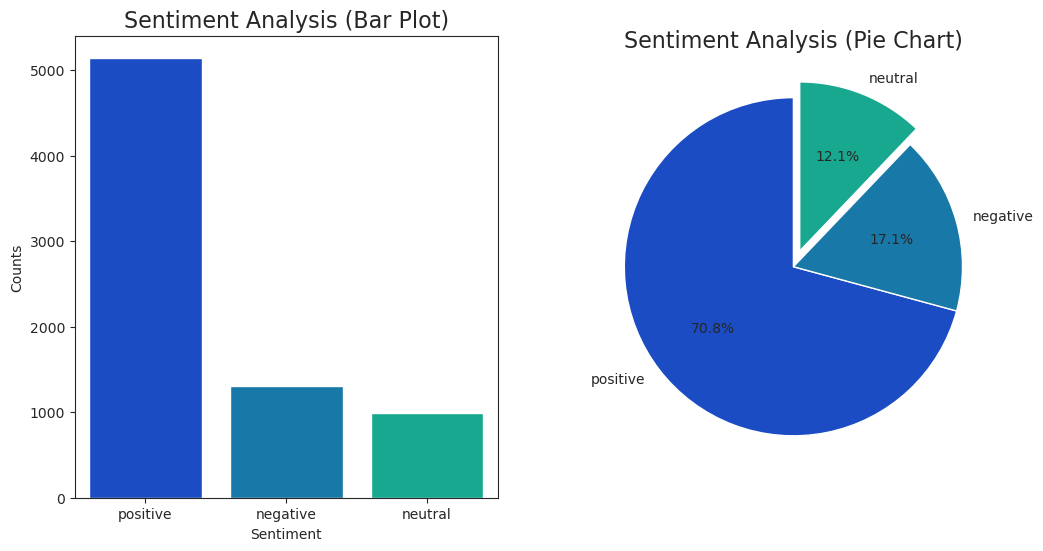

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('ticks')  # set background color to white
sns.set_palette('pastel')  # set palette color to 'pastel'

# membuat figure dan 2 axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# menggambar bar plot di axes pertama
sns.countplot(x=df_hasil["status"],ax=ax1,palette='winter',order=df_hasil["status"].value_counts().index)
ax1.set_title('Sentiment Analysis (Bar Plot)', fontsize=16)
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Counts')

# menggambar pie chart di axes kedua

explode = (0, 0, 0.1)  # memberikan efek explode pada slice pertama
ax2.pie(df_hasil.groupby(['status']).sum().reset_index()['score'].sort_values(ascending=False), explode=explode, 
        labels=['positive','negative','neutral'], autopct='%1.1f%%',
        startangle=90,colors=['#1c4cc3','#1878a7','#18a88f'])
ax2.set_title('Sentiment Analysis (Pie Chart)', fontsize=16)

# menampilkan figure
plt.show()

In [58]:
remove_short_words = lambda s: ' '.join(filter(lambda w: len(w) > 3, s.split()))

# apply the function to the 'text' column of the DataFrame
clean_df['reviews'] = clean_df['reviews'].apply(remove_short_words)

# print the updated DataFrame
clean_df

,reviews
0,dengar vidio klip snag badut raim laode
1,keren bang
2,specless
3,terima kasih rana bawa lagu dunia
4,video wedding tonton indonesia moga jadi kelua...
...,...
7448,tahun lalu
7449,mantap
7450,pernah bosen dengerin lagu syair lagu ragu par...
7451,best


In [77]:
# I created the following data frame as a benchmark as ready-clean data 
clean_df = pd.DataFrame(df_hasil['Text'].tolist(), columns=['reviews'])
clean_df

,reviews
0,dengar vidio klip snag badut raim laode
1,keren bang
2,specless
3,terima kasih rana bawa lagu dunia
4,video wedding tonton indonesia moga keluarga s...
...,...
7448,
7449,mantap
7450,nggak bosen dengerin lagu syair lagu nggak rag...
7451,best


# Word Analysis

In [78]:
from sklearn.feature_extraction.text import CountVectorizer

# initiate object to  CountVectorizer
vectorizer = CountVectorizer()

# transform data to vector
X = vectorizer.fit_transform(clean_df['reviews'])

# caunting how many the word appear then sorted descending order
word_counts = dict(zip(vectorizer.get_feature_names(), X.sum(axis=0).tolist()[0]))
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# print the top ten the word that appears the most in the review just for checking
print(sorted_word_counts[:10])

[('lagu', 2478), ('raim', 1284), ('bang', 1180), ('komang', 923), ('indah', 798), ('keren', 654), ('video', 602), ('moga', 566), ('banget', 511), ('karya', 448)]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [79]:
#Save them on pandas data frame
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
df_word_counts = pd.DataFrame(sorted_word_counts, columns=['Word', 'Frequency'])
df_word_counts.head(10)

,Word,Frequency
0,lagu,2478
1,raim,1284
2,bang,1180
3,komang,923
4,indah,798
5,keren,654
6,video,602
7,moga,566
8,banget,511
9,karya,448


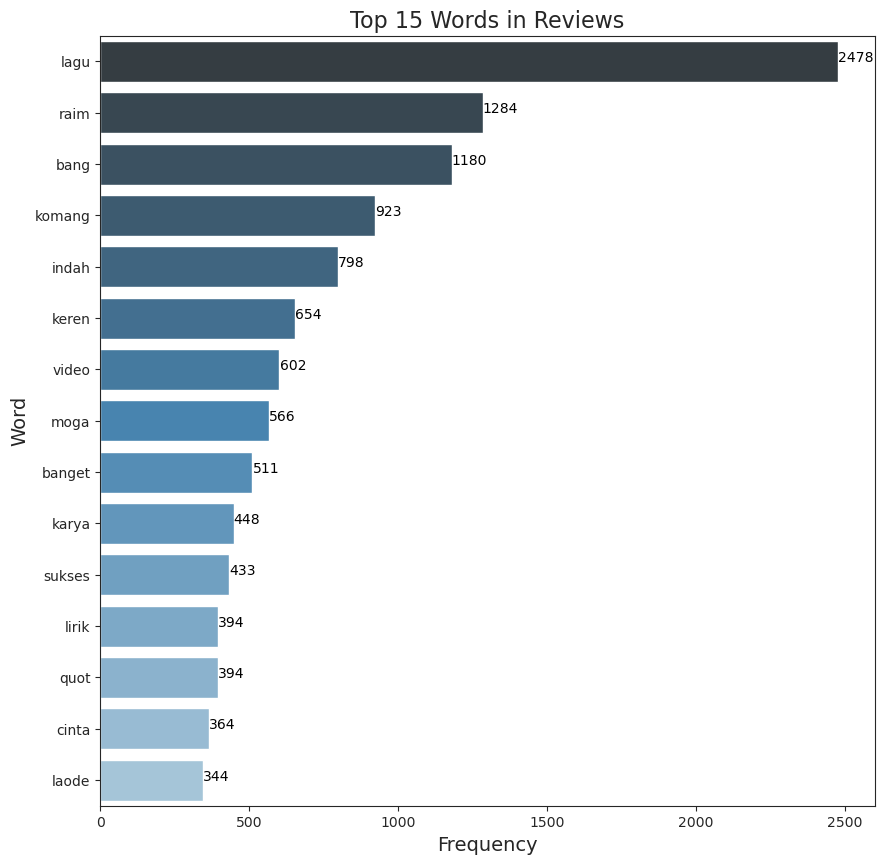

In [87]:
plt.figure(figsize=(10,10))
# setting how many rows or data will be visualized
top_words = df_word_counts.nlargest(15, 'Frequency')
sns.barplot(x='Frequency', y='Word', data=top_words, palette= sns.color_palette("Blues_d", n_colors=15)[::-1])
plt.ylabel('Word', fontsize=14)
plt.xlabel('Frequency', fontsize=14)
plt.title('Top 15 Words in Reviews', fontsize=16)
# Give anotation number for every bar
for i, v in enumerate(top_words['Frequency']):
    plt.text(v + 0.5, i, str(v), color='black', fontsize=10)

## Wordcloud

# Bigrams Analysis

In [80]:
import re
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing text
clean_df['clean_reviews'] = clean_df['reviews'].apply(lambda x: re.sub(r'[^\w\s]','',x.lower()))

# Tokenization
clean_df['tokens'] = clean_df['clean_reviews'].apply(lambda x: x.split())

# Bigram
clean_df['bigrams'] = clean_df['tokens'].apply(lambda x: [x[i] + " " + x[i+1] for i in range(len(x)-1)])

# Counting bigram frequency
bigram_freq = Counter([item for sublist in clean_df['bigrams'] for item in sublist])

# Creating DataFrame for top 15 bigrams
bigrams_df = pd.DataFrame(bigram_freq.most_common(), columns=['Bigram', 'Frequency'])
bigrams_df.head(15)

,Bigram,Frequency
0,bang raim,422
1,raim laode,282
2,lagu indah,157
3,video klip,134
4,raim komang,125
5,terima kasih,122
6,masya allah,119
7,banget lagu,93
8,sukses bang,92
9,keren bang,87


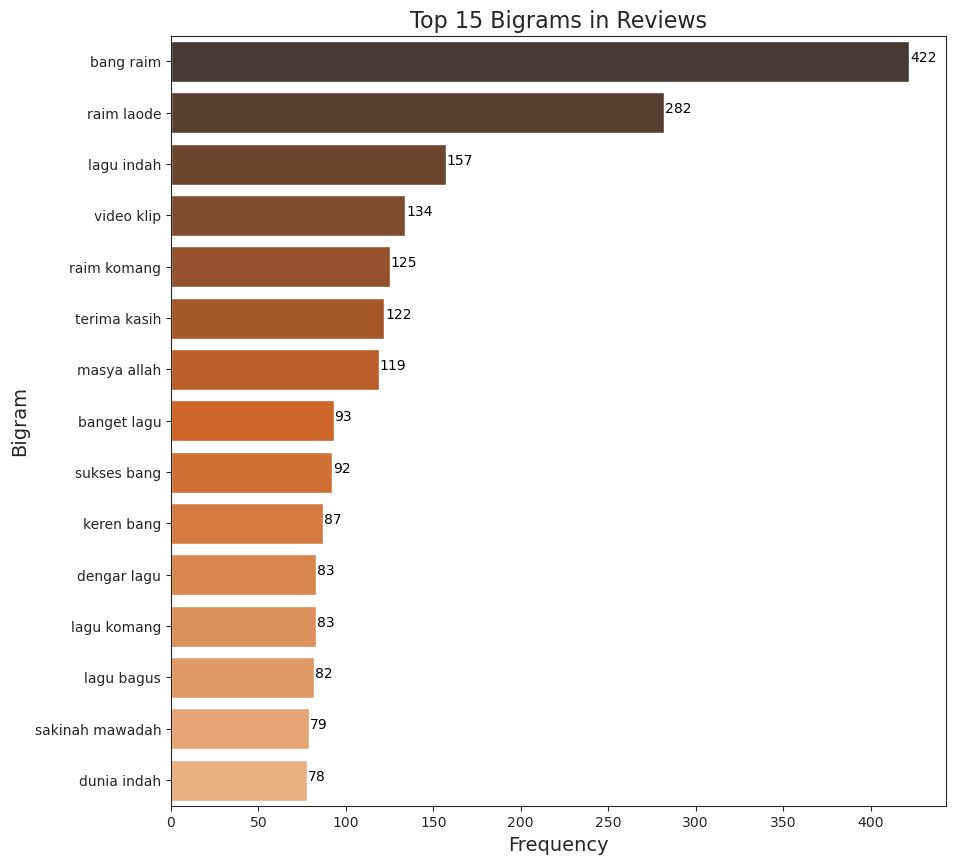

In [88]:
plt.figure(figsize=(10,10))
top_bigrams = bigrams_df.nlargest(15, 'Frequency')
sns.barplot(x='Frequency', y='Bigram', data=top_bigrams, palette= sns.color_palette("Oranges_d", n_colors=15)[::-1])
plt.ylabel('Bigram', fontsize=14)
plt.xlabel('Frequency', fontsize=14)
plt.title('Top 15 Bigrams in Reviews', fontsize=16)
# Give anotation number for every bar
for i, v in enumerate(top_bigrams['Frequency']):
    plt.text(v + 0.5, i, str(v), color='black', fontsize=10)

# Trigrams analysis

In [92]:
from collections import defaultdict
positiveValues3=defaultdict(int)
negativeValues3=defaultdict(int)
neutralValues3=defaultdict(int)
TrigramValues3=defaultdict(int)
#get the count of every word in both the columns of df_train and df_test dataframes

In [93]:
def generate_N_grams(text,ngram=1):
  words=[word for word in text.split(" ")]  
  print("Sentence after removing stopwords:",words)
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

In [97]:
#get the count of every word in both the columns of df_train and df_test dataframes
for text in df_hasil.Text:
  for word in generate_N_grams(text,3):
    TrigramValues3[word]+=1
#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in df_hasil[df_hasil.status=="positive"].Text:
  for word in generate_N_grams(text,3):
    positiveValues3[word]+=1
#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="negative"
for text in df_hasil[df_hasil.status=="negative"].Text:
  for word in generate_N_grams(text,3):
    negativeValues3[word]+=1
#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="neutral"
for text in df_hasil[df_hasil.status=="neutral"].Text:
  for word in generate_N_grams(text,3):
    neutralValues3[word]+=1#focus on more frequently occuring words for every sentiment=>

Sentence after removing stopwords: ['dengar', 'vidio', 'klip', 'snag', 'badut', 'raim', 'laode']
Sentence after removing stopwords: ['keren', 'bang']
Sentence after removing stopwords: ['specless']
Sentence after removing stopwords: ['terima', 'kasih', 'rana', 'bawa', 'lagu', 'dunia']
Sentence after removing stopwords: ['video', 'wedding', 'tonton', 'indonesia', 'moga', 'keluarga', 'sakinah', 'mawaddah', 'warahmah']
Sentence after removing stopwords: ['emak', 'kali', 'hehe', 'selamat', 'bang']
Sentence after removing stopwords: ['lagu', 'bagus']
Sentence after removing stopwords: ['kadang', 'ngeri', 'sedap', 'kisah', 'cinta', 'buah', 'lagu', 'angkat', 'tuju', 'komersial', 'khawatir', 'lagu', 'surat', 'cinta', 'starling', 'virguon', 'indah', 'tulis', 'lagu', 'nyata', 'beda', 'pikir', 'laku', 'cipta', 'lagu', 'cipta', 'lagu', 'nasib', 'pasang', 'contoh']
Sentence after removing stopwords: ['syaa', 'allah', 'nyata', 'suara', 'raim', 'laode', 'bagus']
Sentence after removing stopwords: ['s

In [103]:
df_trigram3=pd.DataFrame(sorted(TrigramValues3.items(),key=lambda x:x[1],reverse=True))
df_positive3=pd.DataFrame(sorted(positiveValues3.items(),key=lambda x:x[1],reverse=True))
df_negative3=pd.DataFrame(sorted(negativeValues3.items(),key=lambda x:x[1],reverse=True))
df_neutral3=pd.DataFrame(sorted(neutralValues3.items(),key=lambda x:x[1],reverse=True))
df_trigram1=df_trigram3[0][:10]
df_trigram2=df_trigram3[1][:10]
pd1tri=df_positive3[0][:10]
pd2tri=df_positive3[1][:10]
ned1tri=df_negative3[0][:10]
ned2tri=df_negative3[1][:10]
nud1tri=df_neutral3[0][:10]
df_trigram3df.rename(columns={"A": "a", "B": "c"})

,0,1
0,jalan dunia indah,73
1,bang raim laode,68
2,dunia indah kemarinsederhana,54
3,indah kemarinsederhana tertawa,54
4,kemarinsederhana tertawa cukuplengkapi,54
...,...,...
28490,laode karya hati,1
28491,best lagu bang,1
28492,bang keren beneran,1
28493,keren beneran indah,1


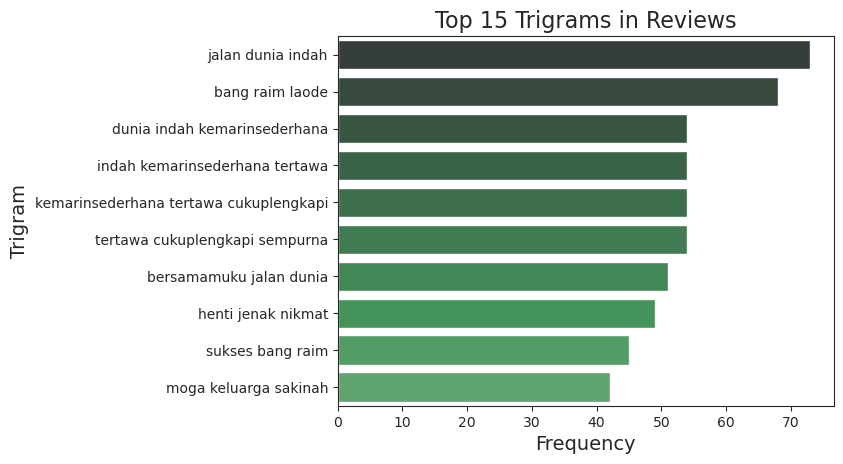

In [101]:
top_trigrams = trigrams_df.nlargest(15, 'Frequency')
sns.barplot(x=df_trigram2, y=df_trigram1, data=df_trigram3, palette= sns.color_palette("Greens_d", n_colors=15)[::-1])
plt.ylabel('Trigram', fontsize=14)
plt.xlabel('Frequency', fontsize=14)
plt.title('Top 15 Trigrams in Reviews', fontsize=16)

# Give anotation number for every bar
for i, v in enumerate(top_trigrams['Frequency']):
    plt.text(v + 0.5, i, str(v), color='black', fontsize=10)

Text(0.5, 1.0, 'Top 15 Trigrams Neutral in Reviews')

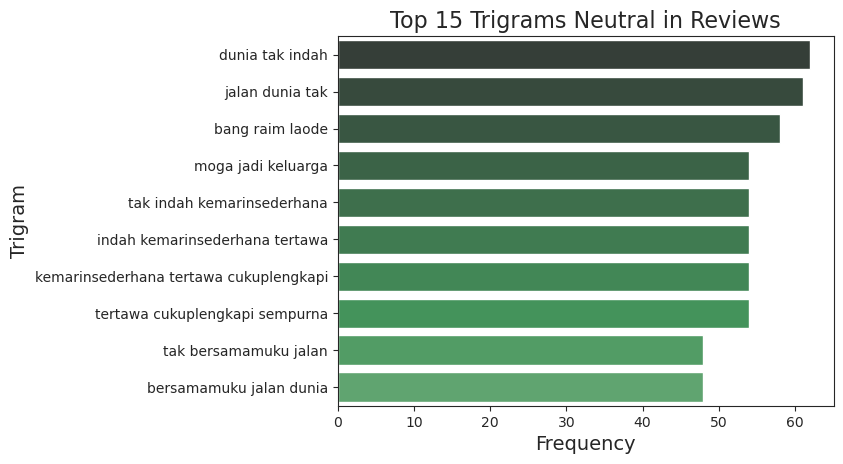

In [108]:
sns.barplot(x=pd2tri, y=pd1tri, data=df_positive3, palette= sns.color_palette("Greens_d", n_colors=15)[::-1])
plt.ylabel('Trigram', fontsize=14)
plt.xlabel('Frequency', fontsize=14)
plt.title('Top 15 Trigrams Neutral in Reviews', fontsize=16)

Text(0.5, 1.0, 'Top 15 Trigrams Neutral in Reviews')

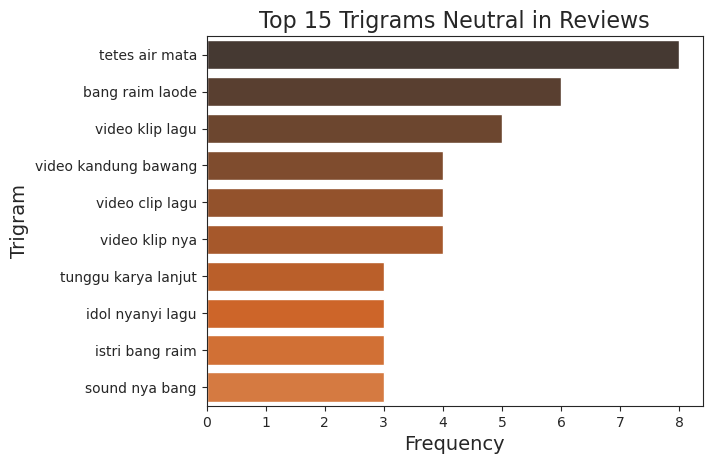

In [106]:
sns.barplot(x=nud2tri, y=nud1tri, data=df_neutral3, palette= sns.color_palette("Oranges_d", n_colors=15)[::-1])
plt.ylabel('Trigram', fontsize=14)
plt.xlabel('Frequency', fontsize=14)
plt.title('Top 15 Trigrams Neutral in Reviews', fontsize=16)

Text(0.5, 1.0, 'Top 15 Trigrams Negative in Reviews')

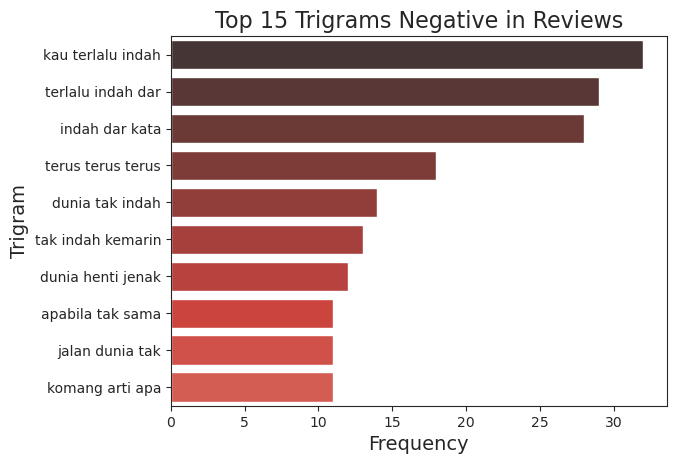

In [105]:
sns.barplot(x=ned2tri, y=ned1tri, data=df_negative3, palette= sns.color_palette("Reds_d", n_colors=15)[::-1])
plt.ylabel('Trigram', fontsize=14)
plt.xlabel('Frequency', fontsize=14)
plt.title('Top 15 Trigrams Negative in Reviews', fontsize=16)